In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

import numpy as np 

import torch_utils; importlib.reload(torch_utils)
from torch_utils import *

import random 
from collections import OrderedDict

import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
from torch import optim
import torchvision.utils as vutils

In [2]:
cudnn.benchmark = True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Fix seed
manual_seed = random.randint(1, 4444)
print(manual_seed)
random.seed(manual_seed)
torch.manual_seed(manual_seed)

653


Use pytorch embedded datasets

In [5]:
batch_size = 128
ngpu = 2
lr = 1e-4
num_epochs = 120
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

In [8]:
PATH = 'data/cifar10'
data = datasets.CIFAR10(root=PATH, download=True,
    transform=transforms.Compose([
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

Files already downloaded and verified


In [9]:
dataloader = DataLoader(data, batch_size = batch_size, shuffle = True, num_workers=8)
n = len(dataloader)
n

/home/kexin/.conda/envs/pytorch_env/lib/python3.8/site-packages/torch/utils/data/dataloader.py:474: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


391

## Create Model

In [10]:
class Generator(nn.Module): 
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )
        
    def forward(self, input):
        return self.main(input)

In [11]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(512, 1, 4, 1, 0),
        )
        
    def forward(self, input): #Returns: A four-dimensional vector (NCHW).
        return self.main(input)

In [12]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        m.weight.data.normal_(0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [13]:
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

netG

DataParallel(
  (module): Generator(
    (main): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2

In [14]:
netD = Discriminator(ngpu).to(device)
if (device == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
netD.apply(weights_init)
netD

DataParallel(
  (module): Discriminator(
    (main): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    )
  )
)

In [15]:
optimizerG = optim.RMSprop(netG.parameters(), lr=lr)
optimizerD = optim.RMSprop(netD.parameters(), lr=lr)

In [16]:
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(128, nz, 1, 1, device=device)

## Training

In [17]:
G_losses = []
D_losses = []
iters = 0

In [18]:
num_epochs = 20

for epoch in range(num_epochs):
#     one = torch.FloatTensor([1]).to(device)
#     mone = one * -1.to(device)
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) - log(D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        
        # Clip weights of discriminator
        for p in netD.parameters():
            p.data.clamp_(-0.01, 0.01)
            
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = torch.mean(output)
        # Calculate gradients for D in backward pass
        
        D_x = output.mean().item()
        errD_real.backward()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = -torch.mean(output)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        D_G_z1 = output.mean().item()
        errD_fake.backward()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

       

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = torch.mean(output)
        # Calculate gradients for G
        D_G_z2 = output.mean().item()
        errG.backward()
        # Update G
        optimizerG.step()


        # Output training stats
        if i % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 100 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach()
            vutils.save_image(real_cpu, 'output/WGAN/real_samples.png', normalize=True)
            vutils.save_image(fake, 'output/WGAN/fake_samples_epoch_%03d.png' % epoch, normalize=True)

        # Check pointing for every epoch
        torch.save(netG.state_dict(), 'weights/WGAN/netG_epoch_%d.pth' % (epoch))
        torch.save(netD.state_dict(), 'weights/WGAN/netD_epoch_%d.pth' % (epoch))

        iters += 1


[0/20][0/391]	Loss_D: 0.0003	Loss_G: 0.0706	D(x): 0.0103	D(G(z)): 0.0100 / 0.0706
[0/20][100/391]	Loss_D: -0.5546	Loss_G: 0.3363	D(x): -0.2519	D(G(z)): 0.3026 / 0.3363
[0/20][200/391]	Loss_D: -0.4999	Loss_G: 0.2977	D(x): -0.2304	D(G(z)): 0.2695 / 0.2977
[0/20][300/391]	Loss_D: -0.4092	Loss_G: 0.4294	D(x): -0.2607	D(G(z)): 0.1485 / 0.4294
[1/20][0/391]	Loss_D: -0.2960	Loss_G: -0.0590	D(x): 0.0484	D(G(z)): 0.3444 / -0.0590
[1/20][100/391]	Loss_D: -0.3380	Loss_G: 0.2210	D(x): -0.1045	D(G(z)): 0.2334 / 0.2210
[1/20][200/391]	Loss_D: -0.2985	Loss_G: 0.3798	D(x): -0.4433	D(G(z)): -0.1448 / 0.3798
[1/20][300/391]	Loss_D: -0.3399	Loss_G: -0.0741	D(x): 0.0206	D(G(z)): 0.3604 / -0.0741
[2/20][0/391]	Loss_D: -0.4490	Loss_G: 0.4056	D(x): -0.3212	D(G(z)): 0.1277 / 0.4056
[2/20][100/391]	Loss_D: -0.4991	Loss_G: 0.3626	D(x): -0.3110	D(G(z)): 0.1881 / 0.3626
[2/20][200/391]	Loss_D: -0.2792	Loss_G: 0.0964	D(x): 0.0864	D(G(z)): 0.3656 / 0.0964
[2/20][300/391]	Loss_D: -0.4256	Loss_G: -0.2266	D(x): -0.044

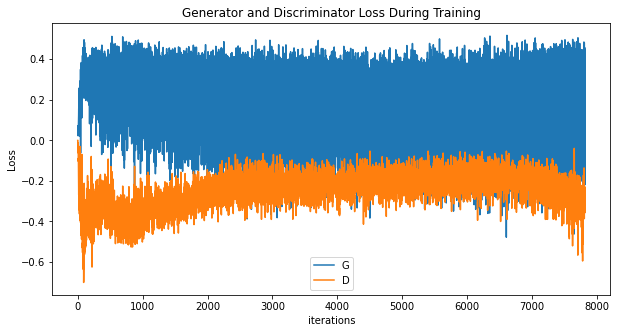

In [19]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
vutils.save_image(real_cpu, 'output/WGAN/real/real.png', normalize=True)
vutils.save_image(fake, 'output/WGAN/fake/fake.png', normalize=True)